In [5]:
import pandas as pd
from pandas import concat
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D

In [6]:
class AutoCNN():
    
    '''
    Vector Autoregression model

    Attributes
    ----------
    self.data_backup: dataframe, a backup copy of the input dataset
    self.data: dataframe, the main dataset worked on
    self.n: int, length (unit in months) of target to predict
    self.df_result: dataframe, stores the predicted target and the true target
    self.lag: int, number of past months used to predict the target
    self.rmse: rounded RMSE of the prediction
    self.target: str, name of target variable
    self.model: record a CNN trained model
    self.train_result: record model fit result loss
    
    Params
    ----------
    data_name: str, name of the dataset. Notice the input dataset must contain a column named 'Date'
    target_name: str, name of target variable
    drop_cols: list of strings, names of columns to drop
    '''
    def __init__(self, data_name, target_name, drop_cols=['Date']):   
        #import data
        curr_path = os.getcwd()
        input_path = os.path.join(curr_path, data_name)
        data = pd.read_excel(input_path, index_col=0)
        
        #drop columns and na
        data.drop(drop_cols, axis=1, inplace=True)
        data.dropna(inplace = True)
        # data.reset_index(drop=True, inplace=True)
        
        #set attributes
        self.data = data
        self.n = 0
        self.df_result = 0
        self.lag = 0
        self.column_name = []
        self.rmse = 0
        self.target = target_name
        self.n_features = len(data.columns) - 1
        self.model = 0
        self.train_result = 0
        
        
    def series_to_supervised(self, data, n_in=1, n_out=1, dropnan=True, if_target=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        df_without_target = df.loc[:, df.columns[1:]]
        cols, names = list(), list()
        if if_target:
            for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
            for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                    names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            agg = concat(cols, axis=1)
            agg.columns = names
        else:
            for i in range(n_in, 0, -1):
                cols.append(df_without_target.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(1, n_vars)]
            for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                    names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            agg = concat(cols, axis=1)
            agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    

    def run(self, pred_begin_date, n, use_target=True, lags=3, leads=1): 
        ''' Run CNN
        
        Params
        ----------
        pred_begin_date: date, the begin date of prediction
        n: int, length of prediction (unit in months)      
        lag: int, num of past months to consider
        if_target: boolean, whether to include target as a predictor
        '''

        # normalize features
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(self.data)
        # flatten data
        reframed = self.series_to_supervised(scaled, lags, leads, True, use_target)
        # drop columns we don't want to predict
        reframed.drop(reframed.columns[range(reframed.shape[1] - self.n_features, reframed.shape[1])], axis=1, inplace=True)
        reframed.drop(reframed.columns[range(reframed.shape[1] - 1 - (leads - 1) * (self.n_features + 1), reframed.shape[1]-1)], axis=1, inplace=True)
        
        values = reframed.values
        self.n = n

        test_date_begin = self.data.index.get_loc(pred_begin_date) - lags - leads + 1
        
        train = values[:test_date_begin, :]
        test = values[test_date_begin: test_date_begin+self.n, :]

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
                
        # reshape data and normalize data
        if use_target:
            features  = self.n_features+1
            train_X_reshaped = np.array(train_X).reshape(len(train_X), lags, self.n_features+1, 1)
            test_X_reshaped = np.array(test_X).reshape(len(test_X), lags, self.n_features+1, 1)
        else:
            features = self.n_features
            train_X_reshaped = np.array(train_X).reshape(len(train_X), lags, self.n_features, 1)
            test_X_reshaped = np.array(test_X).reshape(len(test_X), lags, self.n_features, 1)            

        #build CNN model
        model = Sequential()
        model.add(Conv2D(filters = 32, 
                         input_shape = ((lags, features,1)),
                         data_format = 'channels_last',
                         kernel_size=(2,2), 
                         strides=(1,1),   
                         activation='relu'))
        #model.add(MaxPooling2D(pool_size=(2, 1)))
        #model.add(AveragePooling2D(pool_size=(2,1)))
        model.add(Flatten())
        model.add(Dense(45, activation='relu'))
        model.add(Dense(1))
        
        def root_mean_squared_error(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
        model.compile(optimizer='adam', loss=root_mean_squared_error)
        
        result = model.fit(train_X_reshaped, train_y, verbose=0, validation_data=(test_X_reshaped, test_y), epochs=20)
        self.model = model
        self.train_result = result
        
        pred_y = self.model.predict(test_X_reshaped)
        pred_y = pred_y.reshape((len(pred_y), 1))
        
        if use_target:
            inv_yhat = np.concatenate((pred_y, test_X[:, 1:features]), axis=1)
        else:
            inv_yhat = np.concatenate((pred_y, test_X[:, :features]), axis=1)
        
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual

        test_y = test_y.reshape((len(test_y), 1))
        inv_y = np.concatenate((test_y, test_X[:, 1:self.n_features+1]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)

        df_result = pd.DataFrame(inv_yhat, columns=[self.target + '_pred'])
        df_result[self.target] = inv_y

        ### TODO modify range

        df_result['Date'] = self.data.index[test_date_begin + lags+leads-1:  test_date_begin+lags+n+leads-1]
        df_result.set_index(['Date'],inplace=True)

        self.df_result = df_result
        self.rmse = round(rmse,2)  

Test RMSE: 132.468


<AxesSubplot:xlabel='Date'>

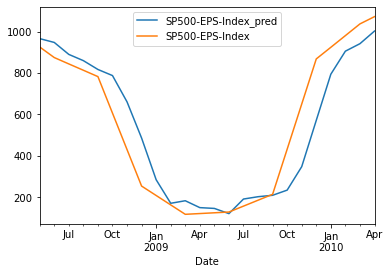

In [7]:
cnn_model = AutoCNN(data_name='data_1107.xlsx', target_name='SP500-EPS-Index', drop_cols=[])
d = '2008-05-01 00:00:00'
n = 24
lag = 2
lead = 1
cnn_model.run(pred_begin_date=d, n=n, use_target=True, lags=lag, leads=lead)
cnn_model.df_result.plot()

Test RMSE: 348.857


<AxesSubplot:xlabel='Date'>

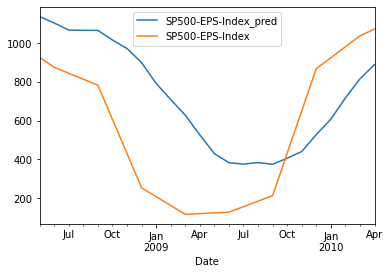

In [8]:
cnn_model = AutoCNN(data_name='data_1107.xlsx', target_name='SP500-EPS-Index', drop_cols=[])
d = '2008-05-01 00:00:00'
n = 24
l = 12
cnn_model.run(pred_begin_date=d, n=n, use_target=True, lags=l)
cnn_model.df_result.plot()